# TP6 - Procesamiento de Lenguaje Natural

Imports

In [352]:
import pandas as pd
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
import itertools
import random
import math
import operator
import re
import nltk
import string
import xml.etree.ElementTree as et
from random import shuffle
from heapq import nsmallest
from nltk.corpus import wordnet
from lxml import etree
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
from nltk.corpus import stopwords
from sympy import *
wnl = WordNetLemmatizer()
sns.plt = plt
# nltk.download()

## 1 - Asociacion de palabras
1.1 Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario ( < doc_no > : < text > ).

Librerias necesarias: html5lib, lxml, bs4, re

In [9]:
ap_xml_data = open('data/ap.txt').read()
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
tokenizer = nltk.tokenize.TreebankWordTokenizer()

def word_normalize(txt):
    return txt.translate(None, string.punctuation).lower() #.replace("'", "")

def xml2df(xml_data):
    root = et.XML(xml_data, parser=etree.XMLParser(recover=True)) # element tree
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            if subchild.tag=="DOCNO":
                record[subchild.tag] = subchild.text
            elif subchild.tag=="TEXT":
                record[subchild.tag] = beautify(word_normalize(subchild.text))
        all_records.append(record)
    df = pd.DataFrame(all_records)
    df.set_index('DOCNO', inplace=True)
    return df

def split(text):
    sentences = sent_detector.tokenize(text)
    tokens = [tokenizer.tokenize(sent) for sent in sentences]
    return tokens

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def pos_tag(tokens):
    pos_tokens = [nltk.pos_tag(token) for token in tokens]
    pos_tokens = [[(word, wnl.lemmatize(word,get_wordnet_pos(pos_tag)), [pos_tag]) 
                  for (word,pos_tag) in filter(lambda (w,t): get_wordnet_pos(t) != None,pos)] 
                  for pos in pos_tokens]
    return pos_tokens

def beautify(txt):
    tokens = split(txt)
    lemma_pos_token = pos_tag(tokens)
    return [w2.encode('utf-8') for sublist in lemma_pos_token for (w1,w2,t) in sublist]

In [150]:
ap_df = xml2df(ap_xml_data)

In [130]:
print "AP cargado."
print "Resumen de los primeros 10 documentos:"
print ap_df.iloc[0:10]

AP cargado.
Resumen de los primeros 10 documentos:
                                                              TEXT
DOCNO                                                             
 AP881218-0003   [16-year-old, student, private, baptist, schoo...
 AP880224-0195   [bechtel, group, inc, offer, sell, oil, israel...
 AP881017-0144   [gunman, take, 74-year-old, woman, hostage, be...
 AP881017-0219   [today, be, saturday, day, be, day, leave, yea...
 AP900117-0022   [cupid, have, new, message, lover, valentine, ...
 AP880405-0167   [reagan, administration, be, weigh, invoke, la...
 AP880825-0239   [more, skin, protected, specie, alligator, be,...
 AP880325-0232   [be, organize, union, boost, single, candidate...
 AP880908-0056   [here, be, summary, development, forest, brush...
 AP881105-0097   [jean-pierre, stirbois, man, extreme-right, na...


1.2 Calcular el tamano del vocabulario.

In [131]:
freq_vocab = dict()
for index, row in ap_df.iterrows():
    for word in row[0]:
        freq_vocab[word] = freq_vocab.get(word, 0) + 1

In [132]:
print "El vocabulario tiene: " + str(len(freq_vocab)) + " palabras."

El vocabulario tiene: 32717 palabras.


1.3 Para las 500 palabras con mas apariciones, calcular el par mas asociado segun la medida presentada.

In [133]:
max_freq_vocab = dict(sorted(freq_vocab.iteritems(), key=operator.itemgetter(1), reverse=True)[:500])
print "Se obtuvieron las " + str(len(max_freq_vocab)) + " palabras con mas apariciones."

Se obtuvieron las 500 palabras con mas apariciones.


Usamos PMI:

Sean X,Y palabras, N la cantidad de palabras de todos los textos, W la ventana de co-ocurrencia:

f(X)=occurs(X). f(X,Y)=occurs(Y despues de X, a distancia <= W)/(W-1).

P(X)=f(X)/N. P(X,Y)=f(X,Y)/N.

I(X,Y)=log2(P(X,Y) / (P(X) x P(Y)))=log2( ( f(X,Y) x N ) / ( f(X) x f(Y) ))

In [141]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
def score_associated_pairs(txts, relevant_words, W):
    finder = BigramCollocationFinder.from_words(
        BigramCollocationFinder._build_new_documents(txts, BigramCollocationFinder.default_ws, pad_right=True),
        window_size=W)
    finder.apply_word_filter(lambda w: w not in relevant_words or w in stopwords.words('english'))
    finder.apply_ngram_filter(lambda w1, w2: w1==w2)
    return finder.score_ngrams(bigram_measures.pmi)
scores = score_associated_pairs(ap_df.iloc[:,0], max_freq_vocab.keys(), 5)

In [142]:
print "10 pares mas asociados:"
print scores[0:10]

10 pares mas asociados:
[(('prime', 'minister'), 7.814928054166025), (('eastern', 'europe'), 7.379277777071842), (('speak', 'condition'), 7.1681626638319536), (('michael', 'dukakis'), 6.9105120703793546), (('human', 'right'), 6.891016830985695), (('west', 'german'), 6.8637168539690485), (('value', 'index'), 6.83568304507687), (('exchange', 'index'), 6.825274779196739), (('news', 'conference'), 6.8132650886796995), (('radio', 'station'), 6.725147577979957)]


In [143]:
print "Palabra mas asociada a cada una de las 500 mas frecuentes (primeras 50):"
most_associated_pairs = dict()
for ((w1,w2),score) in scores[0:50]:
    if w1 not in most_associated_pairs:
        most_associated_pairs[w1] = w2
print most_associated_pairs

Palabra mas asociada a cada una de las 500 mas frecuentes (primeras 50):
{'attorney': 'general', 'financial': 'index', 'sentence': 'prison', 'german': 'mark', 'executive': 'director', 'washington': 'c', 'radio': 'station', 'human': 'right', 'foreign': 'minister', 'george': 'bush', 'speak': 'condition', 'index': 'fell', 'district': 'judge', 'justice': 'department', 'west': 'german', 'exchange': 'index', 'cent': 'low', 'source': 'speak', 'low': 'cent', 'interest': 'rate', 'new': 'york', 'white': 'house', 'east': 'germany', 'tell': 'reporter', 'stock': 'exchange', 'eastern': 'europe', 'southern': 'california', 'news': 'conference', 'communist': 'party', 'presidential': 'candidate', 'prime': 'minister', 'vice': 'president', 'medical': 'center', 'michael': 'dukakis', 'value': 'index', 'n': 'c', 'chief': 'executive', 'airline': 'flight', 'soviet': 'union', 'average': 'point', 'secretary': 'james'}


## 2 -  Informacion Lexica
Bajar de Project Gutenberg el libro de Darwin ON THE ORIGIN OF SPECIES.

2.1 Procesar el texto, tokenizando eliminando signos de puntuacion.

In [356]:
origin_txt = open('data/origin.txt').read()
origin_txt = beautify(word_normalize(origin_txt))

In [359]:
print origin_txt[0:50]

['origin', 'specie', 'introduction', 'board', 'hm', 'beagle', 'naturalist', 'i', 'be', 'much', 'struck', 'certain', 'fact', 'distribution', 'organic', 'being', 'inhabit', 'south', 'america', 'geological', 'relation', 'present', 'past', 'inhabitant', 'continent', 'fact', 'be', 'see', 'latter', 'chapter', 'volume', 'seem', 'throw', 'light', 'origin', 'speciesthat', 'mystery', 'mystery', 'have', 'be', 'call', 'great', 'philosopher', 'return', 'home', 'occur', 'something', 'perhaps', 'be', 'make']


2.2 Siguiendo el artıculo de la seccion, calcular la autocorrelacion para estimar la distribucion de la palabra a lo largo del texto.

In [318]:
def gaussian_kernel(t,sigma):
    return scipy.stats.norm.pdf(t, 0.0, sigma) #(np.e**(-t*t/(2*sigma*sigma)))/(math.sqrt(2*pi)*sigma)

def rate_of_occurence(points_of_interest, word_positions):
    return [sum([gaussian_kernel(t-x,50.0) for x in nsmallest(100, word_positions, key=lambda x: abs(x-t))[::2]]) for t in points_of_interest]

Vamos a testear las funciones para la palabra "instinct", la cual es usa en el paper:

In [380]:
def calculate_word_occurs(txt):
    occurs = dict()
    for i in range(len(txt)):
        word = txt[i]
        if (word in example_words):
            occurs[word] = occurs.get(word,[]) + [i]
    return occurs

example_words = ["instinct"]
example_word_occurs = calculate_word_occurs(origin_txt)
N = len(origin_txt)

In [369]:
POINT_STEP = 150
points_of_interest = range(0,N,POINT_STEP)
example_word_rates = dict()
for word in example_words:
    example_word_rates[word] = rate_of_occurence(points_of_interest, example_word_occurs[word]) #[rate_of_occurence(i,example_word_occurs[word]) for i in points_of_interest]

In [364]:
rate_df = pd.DataFrame(example_word_rates["instinct"], columns=['Rate'], index=points_of_interest)

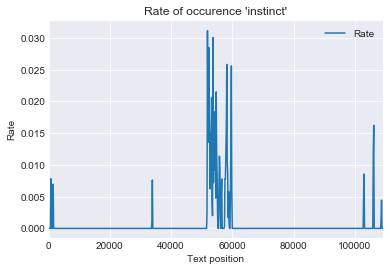

In [365]:
ax = rate_df.plot()
ax.set_title("Rate of occurence 'instinct'")
ax.set_xlabel("Text position")
ax.set_ylabel("Rate")
plt.show()

In [337]:
def autocorrelation(points,word_positions,rates):
    n = len(points)
    sum_rate = sum(rates)
    sum_sq_rate = sum([r*r for r in rates])
    denom = (sum_sq_rate / n) - (sum_rate / n) * (sum_rate / n)
    rates_off = rate_of_occurence(range(N,N+10000,POINT_STEP), word_positions)
    rates_tau = rates
    autocorr = []
    sum_rates = sum(rates)
    sum_rates_tau = sum_rates
    for rate in rates_off:
        sum_comp_rates = sum([rates[i] * rates_tau[i] for i in range(len(rates))])
        autocorr.append((sum_comp_rates / n - (sum_rates / n) * (sum_rates_tau / n)) / denom)
        sum_rates_tau = sum_rates_tau - rates_tau[0] + rate
        rates_tau = rates_tau[1:]
        rates_tau.append(rate)
    return autocorr

Se calcula la autocorrelacion de 'instinct' en el texto:

In [350]:
autocorr = autocorrelation(points_of_interest, example_word_occurs["instinct"], example_word_rates["instinct"])

Se hace un random shuffle del texto y se vuelve a calcular la autocorrelacion de 'instinct':

In [366]:
random_txt = origin_txt[:]
random.shuffle(random_txt)

In [381]:
random_word_occurs = calculate_word_occurs(random_txt)
random_word_rates = dict()
for word in example_words:
    random_word_rates[word] = rate_of_occurence(points_of_interest, random_word_occurs[word])

In [382]:
random_autocorr = autocorrelation(points_of_interest, random_word_occurs["instinct"], random_word_rates["instinct"])
random_autocorr_df = pd.DataFrame(random_autocorr, columns=['Autocorrelation'], index=range(0,10000,POINT_STEP))

Se grafica la autocorrelacion de 'instinct' comparandolo con el caso en que el texto se randomiza:

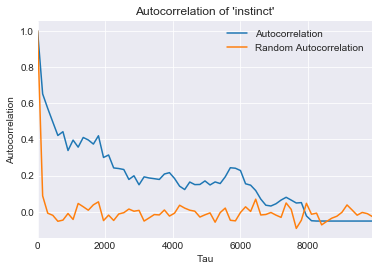

In [386]:
autocorr_df = pd.DataFrame(zip(autocorr,random_autocorr), columns=['Autocorrelation','Random Autocorrelation'], index=range(0,10000,POINT_STEP))
ax = autocorr_df.plot()
ax.set_title("Autocorrelation of 'instinct'")
ax.set_xlabel("Tau")
ax.set_ylabel("Autocorrelation")
plt.show()

2.3 Calcular la entropia de una seleccion de 100 palabras que abarquen el rango de frecuencia de aparicion en el libro, es decir elegir palabras que son muy frecuentes y otras de baja frecuencia.

2.4 Calcular la entropia de las palabras seleccionadas anteriormente, randomizando su posicion en el texto. Comparar con los resultados del punto anterior.

## 3 - Word embeddings, distancia semantica y Word-Net
3.1 Utilizando el test WordSim3531, comparar el rendimiento entre LSA[3] y Word2Vec2 [4].

3.2 Comparar los distintos word embeddings con las medidas definidas en WordNet.